In [1]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 953.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import umap
from PIL import Image, ImageOps
import seaborn as sns
from scipy.optimize import nnls
from skimage.feature import peak_local_max
import ipywidgets as widgets
from ipywidgets import interactive
from datetime import datetime

In [ ]:
#for trial run, we start with penguin dataset...


In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
penguins = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


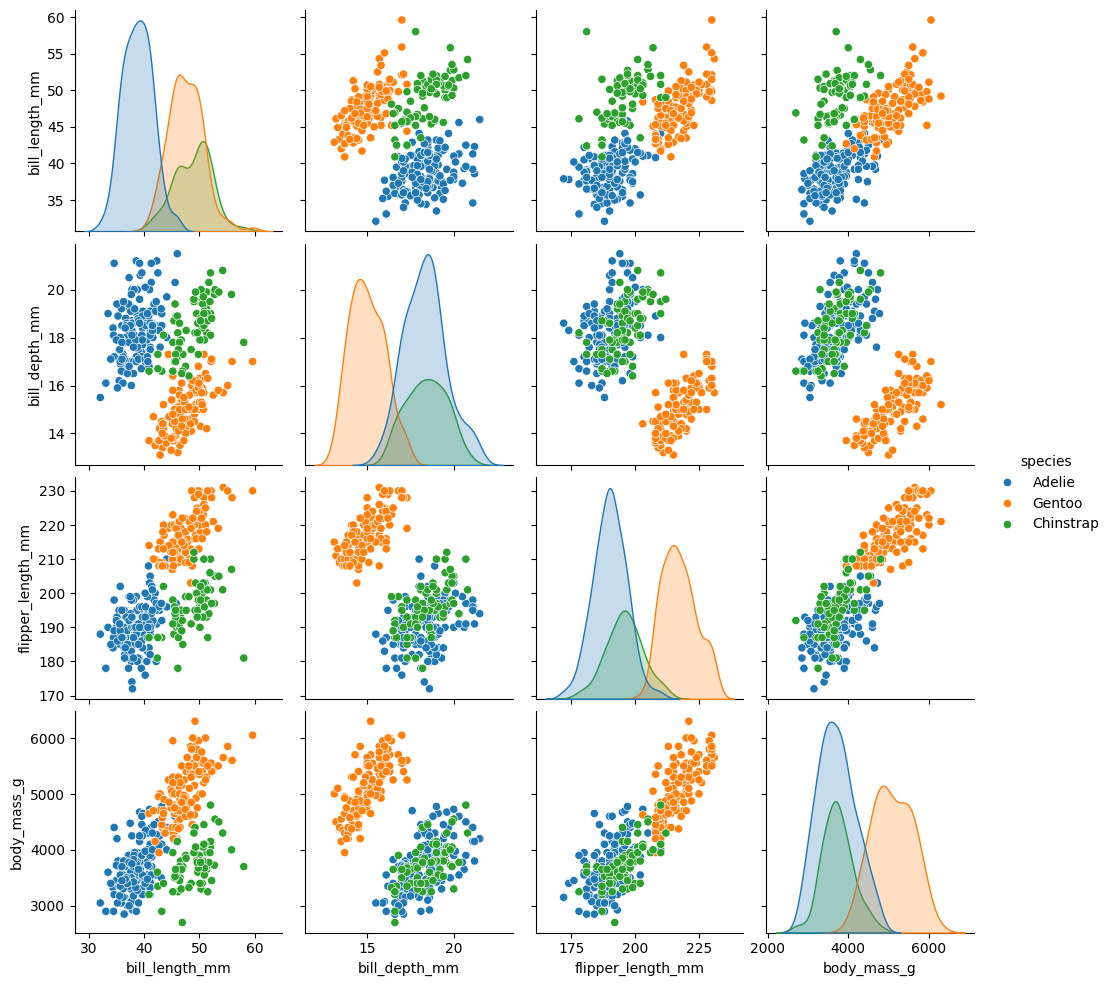

In [ ]:
penguins = penguins.dropna()
penguins.species.value_counts()
sns.pairplot(penguins.drop("year", axis=1), hue='species');


In [ ]:
reducer = umap.UMAP()


In [ ]:
penguin_data = penguins[
    [
        "bill_length_mm",
        "bill_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

In [ ]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(333, 2)

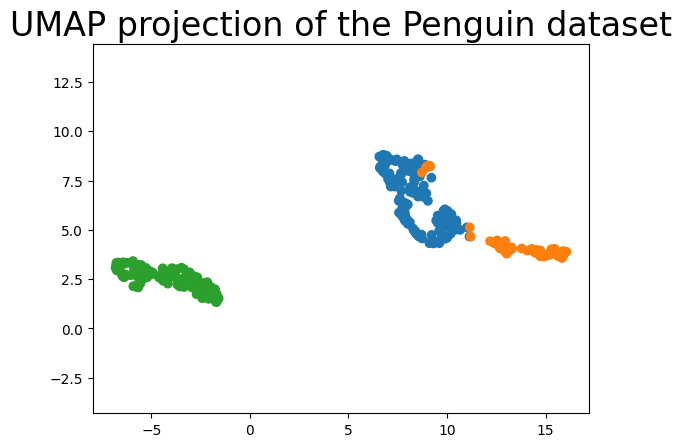

In [ ]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Penguin dataset', fontsize=24);

# UMAP on HSI data - SalinasA

Below is the first attempt at working with UMAP.

Notes:
UMAP accepts a two dimensional image. Thus, for example, when it works with MNIST, it just accepts MNIST.data. (See: documentation)

In our case, with HSI, there are three dimensions. We seek to extend the application of 2D images and UMAP to HSI imagery.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd MyDrive

/content/drive/MyDrive


Below, we load in our dataset.

This is a rewritten version of the MATLAB script from prewritten works (notably, Dr. Murphy's linked repositories)

(Updated from the github version in my repository, to fix small casting errors consistent with typical errors in translation from MATLAB to Python).

In [4]:
#read in the data
import numpy as np
import scipy.io

salinasA_path = '/content/drive/MyDrive/SalinasA_corrected.mat'
salinasA_gt_path = '/content/drive/MyDrive/SalinasA_gt.mat'

data = scipy.io.loadmat(salinasA_path)
HSI = data['salinasA_corrected']

data = scipy.io.loadmat(salinasA_gt_path)
GT = data['salinasA_gt']

M, N, D = HSI.shape
n = M * N
X = HSI.reshape((n, D))
X = X.astype(np.float64)
#normalzie columns

norms = np.sqrt(np.sum(X**2, axis = 0))
X /= norms

X += 1e-6 * np.random.randn(*X.shape)

HSI = X.reshape((M, N, D))

new_gt = np.zeros_like(GT)
unique_classes = np.unique(GT)
K = len(unique_classes)

for k, uc in enumerate(unique_classes, start=1):
    new_gt[GT == uc] = k
n = new_gt.size
Y = new_gt.reshape((n, 1))
GT = new_gt

Sanity check: Shape of all data objects

In [5]:
print(HSI.shape)
print(GT.shape)


(83, 86, 204)
(83, 86)


Below is code that is typical of running the UMAP dimensionality reduction. We note that the HSI data is reshaped to fit the dimensionality needs of UMAP, but consider that it may cause improper clustering.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-6-0a723f37951b>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')


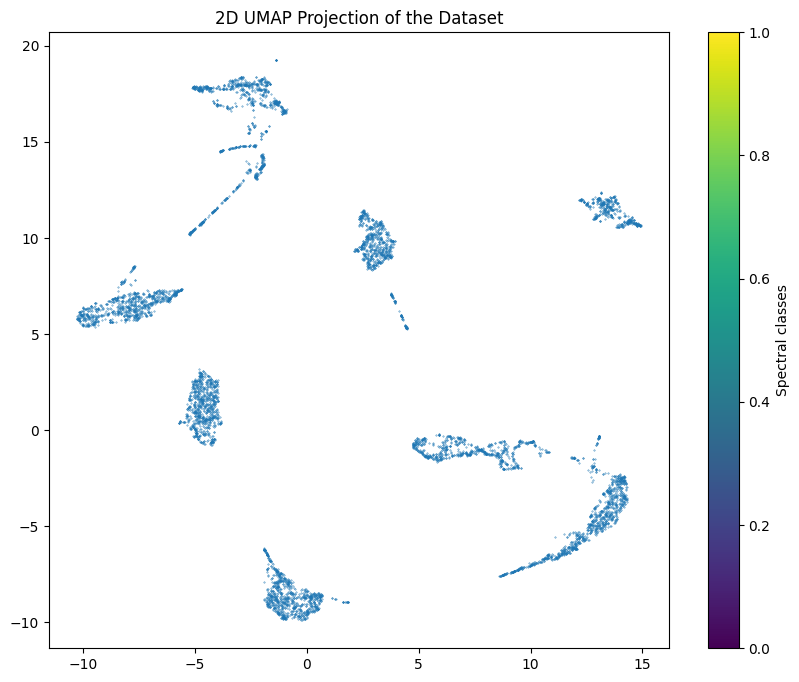

In [6]:
data_reshaped = HSI.reshape(-1, HSI.shape[2])

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(data_reshaped)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=0.1, cmap='Spectral')
plt.title('2D UMAP Projection of the Dataset')
plt.colorbar(label='Spectral classes')
plt.show()

Below is a graph based on ground truth? Still working throguh documenation to decipher what this line of code does, specifically.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


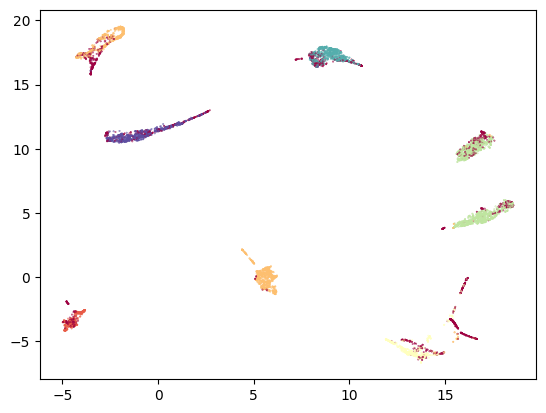

In [7]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(data_reshaped)

plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=GT, s=0.1, cmap='Spectral');

<ipython-input-20-b9cb160c53ad>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)


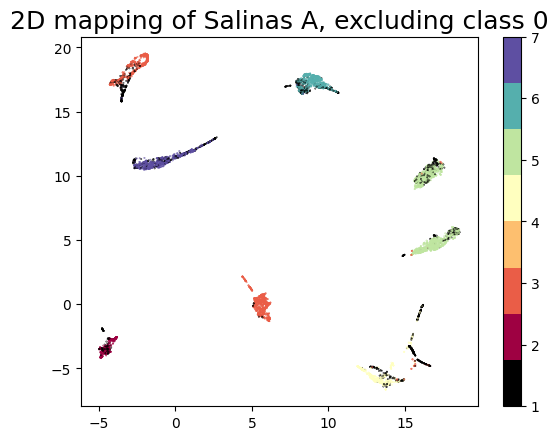

In [20]:
#Adjusting just salinas A for the label 0 difference:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

n_classes = np.max(GT)
spectral_cmap = plt.cm.get_cmap('Spectral', n_classes)
colors = spectral_cmap(np.arange(n_classes))
colors = np.vstack(([[0, 0, 0, 1]], colors))
new_cmap = ListedColormap(colors)

# Plotting the UMAP embedding
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=GT, s=0.1, cmap=new_cmap)
plt.colorbar()  # Optional: to show the color bar
plt.title('2D mapping of Salinas A, excluding class 0', fontsize=18)
plt.show()


In [ ]:
!pip install ffmpeg

In [47]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data_reshaped);
    fig = plt.figure()

    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=GT, s=4)
        plt.title(title, fontsize=18)
        def update(frame):
            ax.view_init(elev=10, azim=frame)
            return fig,

        # Creating the animation
        ani = FuncAnimation(fig, update, frames=range(0, 360, 2), blit=True)

        # To display the animation in Jupyter Notebook
        plt.show()

        # Optionally, save the animation
        ani.save('umap_rotation.mp4', writer='ffmpeg', fps=30)


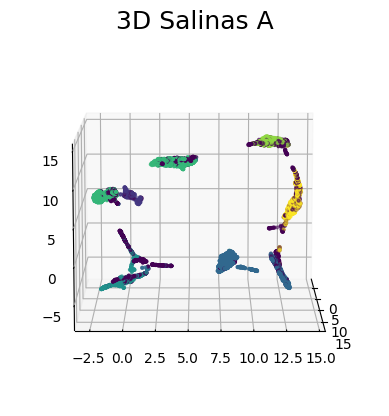

In [48]:
draw_umap(n_components=3,title='3D Salinas A')
#... i need to fix the labels again,,, but thats a later problem... see: above

Now that the data is loaded, we seek to extend the implementation by NU: https://github.com/NU-ACCESS/UMAP/blob/main/Spectral%20Imaging%20Data%20Treatment%20-%20UMAP.ipynb

Look through this and try it with our HSI data.

In [ ]:
#.